In [47]:
import torch
import numpy as np
import torch.nn as nn
import copy
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import lovely_tensors as lt
lt.monkey_patch()
from lovely_numpy import lo

%matplotlib inline
import matplotlib.pyplot as plt

""" automatically reload included modules (need to run import command to trigger reloading) """
%load_ext autoreload
%autoreload 2

import scipy
import json
import cv2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
ROOT_FOLDER = "/datagrid/personal/baljibil"
# prediction

    
with open(ROOT_FOLDER + '/repos/scripts/data/from_vitpose_plus/IMG-coco_small-Rep-mpii.json', 'r') as f:
    annot_hacked_mpii = json.load(f)
with open(ROOT_FOLDER + '/repos/scripts/data/from_vitpose_plus/IMG-coco_small-Rep-aic.json') as f:
    annot_hacked_aic = json.load(f)
with open(ROOT_FOLDER + '/repos/scripts/data/from_vitpose_plus/IMG-coco_small-Rep-coco.json') as f:
    annot_hacked_coco = json.load(f)
with open(ROOT_FOLDER + '/repos/scripts/data/from_vitpose_base_multi/IMG-coco_small-Rep-mpii.json') as f:
    annot_hacked_mpii1 = json.load(f)
    

In [49]:
from mmpose.datasets import build_dataloader, build_dataset
from mmcv import Config, DictAction

cfg = Config.fromfile("/datagrid/personal/baljibil/repos/ViTPose/configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/coco/ViTPose_base_coco_256x192_multi_head.py")


coco_dataset = build_dataset(cfg.data.test, dict(test_mode=True))
annot_truth = coco_dataset.db

loading annotations into memory...
Done (t=1.00s)
creating index...
index created!
=> num_images: 5000
=> load 6352 samples


252219


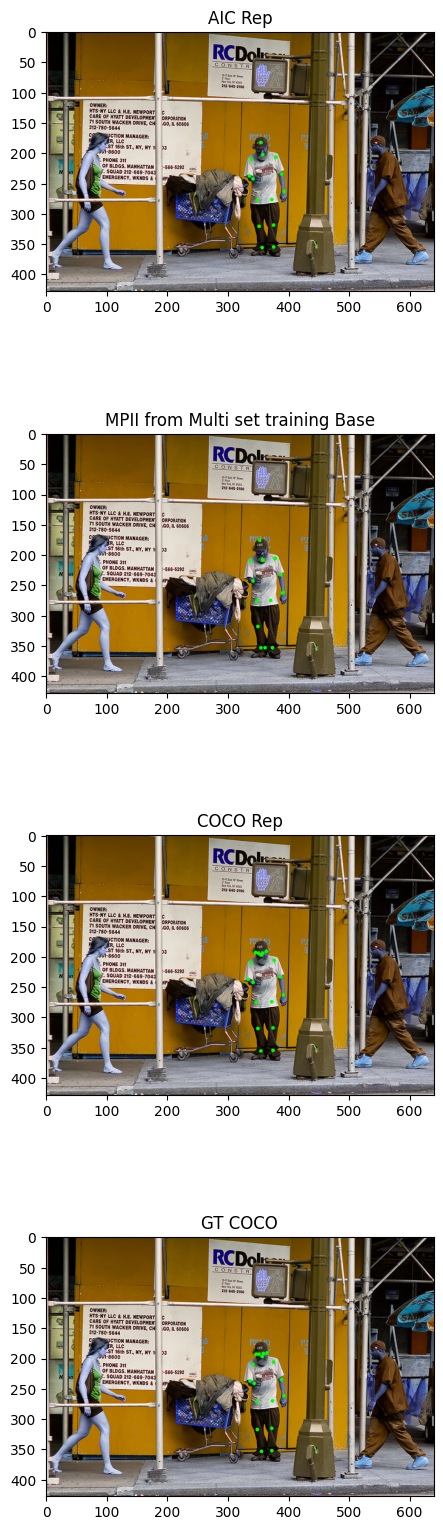

In [51]:
img = 2

fig, axs = plt.subplots(4, 1, figsize=(5, 20))
instance = annot_hacked_aic[img]
print(instance['image_id'])

image = cv2.imread(ROOT_FOLDER + '/data/COCO/original/val2017/' + "000000" + f"{instance['image_id']}.jpg")

for i in range(0,len(instance['keypoints']), 3):
  kp = instance['keypoints']
  x, y = int(kp[i]), int(kp[i+1])
  cv2.circle(image, (x, y), 3, (0, 255, 0, 150), -1)
axs[0].set_title("AIC Rep")
axs[0].imshow(image)


instance = annot_hacked_mpii1[img]
image = cv2.imread(ROOT_FOLDER + '/data/COCO/original/val2017/' + "000000" + f"{instance['image_id']}.jpg")

for i in range(0,len(instance['keypoints']), 3):
  kp = instance['keypoints']
  x, y = int(kp[i]), int(kp[i+1])
  cv2.circle(image, (x, y), 3, (0, 255, 0, 150), -1)
axs[1].set_title("MPII from Multi set training Base")
axs[1].imshow(image)


instance = annot_hacked_coco[img]
image = cv2.imread(ROOT_FOLDER + '/data/COCO/original/val2017/' + "000000" + f"{instance['image_id']}.jpg")

for i in range(0,len(instance['keypoints']), 3):
  kp = instance['keypoints']
  x, y = int(kp[i]), int(kp[i+1])
  cv2.circle(image, (x, y), 3, (0, 255, 0, 150), -1)
axs[2].set_title("COCO Rep")
axs[2].imshow(image)

instance = annot_truth[img]
image = cv2.imread(instance['image_file'])

for i in range(0,len(instance['joints_3d'])):
  kp = instance['joints_3d']
  x, y = int(kp[i][0]), int(kp[i][1])
  cv2.circle(image, (x, y), 3, (0, 255, 0, 150), -1)
axs[3].set_title("GT COCO")
axs[3].imshow(image)

In [46]:
point_pred = [item['keypoints'] for item in annot_hacked_mpii1]
point_pred = np.array(point_pred)
point_pred = point_pred.reshape(point_pred.shape[0], 17, 3)
points_gt = [item['joints_3d'] for item in annot_truth]
# points_gt = [item['joints_3d_visible'] for item in annot_truth]

points_gt = np.array(points_gt)
print("point_pred: ", point_pred.shape)
print("points_gt: ", points_gt.shape)


point_pred:  (6352, 17, 3)
points_gt:  (6352, 17, 3)


## Analyze error on mergeable points

6352